In [1]:
from ComputationalGraphPrimer import ComputationalGraphPrimer
import operator
import random
import numpy as np
from tqdm import tqdm

class SGDPlusMultiNeuron(ComputationalGraphPrimer):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def back_prop_modified(self, y_error, class_labels):
            # backproped prediction error:
            pred_err_backproped_at_layers = {i : [] for i in range(1,self.num_layers-1)}  
            pred_err_backproped_at_layers[self.num_layers-1] = [y_error]
            for back_layer_index in reversed(range(1,self.num_layers)):
                input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
                input_vals_avg = [sum(x) for x in zip(*input_vals)]
                input_vals_avg = list(map(operator.truediv, input_vals_avg, [float(len(class_labels))] * len(class_labels)))
                deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
                deriv_sigmoid_avg = [sum(x) for x in zip(*deriv_sigmoid)]
                deriv_sigmoid_avg = list(map(operator.truediv, deriv_sigmoid_avg, 
                                                                [float(len(class_labels))] * len(class_labels)))
                vars_in_layer  =  self.layer_vars[back_layer_index]                 ## a list like ['xo']
                vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]   ## a list like ['xw', 'xz']

                layer_params = self.layer_params[back_layer_index]         
                ## note that layer_params are stored in a dict like        
                    ##     {1: [['ap', 'aq', 'ar', 'as'], ['bp', 'bq', 'br', 'bs']], 2: [['cp', 'cq']]}
                ## "layer_params[idx]" is a list of lists for the link weights in layer whose output nodes are in layer "idx"
                transposed_layer_params = list(zip(*layer_params))         ## creating a transpose of the link matrix

                backproped_error = [None] * len(vars_in_next_layer_back)
                for k,varr in enumerate(vars_in_next_layer_back):
                    for j,var2 in enumerate(vars_in_layer):
                        backproped_error[k] = sum([self.vals_for_learnable_params[transposed_layer_params[k][i]] * 
                                                pred_err_backproped_at_layers[back_layer_index][i] 
                                                for i in range(len(vars_in_layer))])
    #                                               deriv_sigmoid_avg[i] for i in range(len(vars_in_layer))])
                pred_err_backproped_at_layers[back_layer_index - 1]  =  backproped_error
                input_vars_to_layer = self.layer_vars[back_layer_index-1]
                for j,var in enumerate(vars_in_layer):
                    layer_params = self.layer_params[back_layer_index][j]
                    ##  Regarding the parameter update loop that follows, see the Slides 74 through 77 of my Week 3 
                    ##  lecture slides for how the parameters are updated using the partial derivatives stored away 
                    ##  during forward propagation of data. The theory underlying these calculations is presented 
                    ##  in Slides 68 through 71. 
                    for i,param in enumerate(layer_params):
                        gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j]
                        # @akamsali: update the velocity parameter and use 
                        self.v[param] = gradient_of_loss_for_param * deriv_sigmoid_avg[j] \
                                         + (self.momentum * self.v[param])
                        
                        step = self.learning_rate * self.v[param]
                        
                        self.vals_for_learnable_params[param] += step
                        
                self.v_bias[back_layer_index -1] = (self.learning_rate * sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)) \
                                                                + (self.momentum * self.v_bias[back_layer_index -1])
                self.bias[back_layer_index-1] += self.v_bias[back_layer_index -1]
        ######################################################################################################
    # @akamsali: modified func call name and take in momentum value \mu
    def train(self, training_data, mu=None):


        class DataLoader:
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                


        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}
        # @akamsali: initialise v as 0 for learnable parameters
        self.v = {param: 0 for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.
        # @akamsali: initialise bias velocity to zero 
        self.v_bias = [0] * (self.num_layers-1)

        if mu is None:
            self.momentum = 0
        else:
            self.momentum = mu

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        for i in tqdm(range(self.training_iterations)):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                # print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            # @akamsali: change to modified backprop
            self.back_prop_modified(y_error_avg, class_labels)      ## BACKPROP loss
            
        return loss_running_record

In [2]:
cgp = SGDPlusMultiNeuron(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = 1e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

cgp.parse_multi_layer_expressions()
# cgp.display_multi_neuron_network()   

training_data = cgp.gen_training_data()

# cgp.run_training_loop_multi_neuron_model( training_data )




self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xr', 'xw', 'xs', 'xz', 'xp', 'xq'}


[layer index: 1] learnable params: {'as', 'aq', 'ar', 'br', 'bs', 'bp', 'bq', 'ap'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xr', 'xs', 'xp', 'xq'}


[layer index: 1] leads_to dictionary: {'xr': {'xz', 'xw'}, 'xw': set(), 'xs': {'xz', 'xw'}, 'xz': set(), 'xp': {'xz', 'xw'}, 'xq': {'xz', 'xw'}}


[layer index: 2] all variables: {'xr', 'xo', 'xw', 'xs', 'xz', 'x

In [3]:
loss_0 = cgp.train(training_data)
loss_5 = cgp.train(training_data, mu=0.5)
loss_9 = cgp.train(training_data, mu=0.9)

100%|██████████| 40000/40000 [00:59<00:00, 675.02it/s]


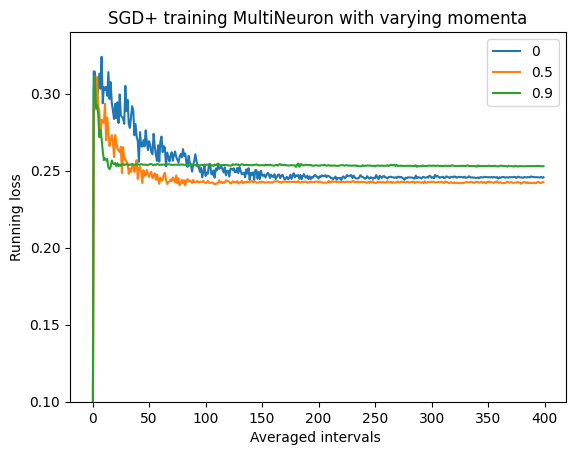

In [4]:
import matplotlib.pyplot as plt
plt.plot(loss_0, label=0)
plt.plot(loss_5, label='0.5')
plt.plot(loss_9, label='0.9')
plt.legend()
plt.ylim(bottom=0.1)
plt.title("SGD+ training MultiNeuron with varying momenta")
plt.ylabel("Running loss")
plt.xlabel("Averaged intervals ")
plt.savefig('sgdp_mn_059.png')